In [15]:
# Run this cell to import the packages you'll need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sql
import re

from collections import Counter
from operator import itemgetter

%matplotlib inline

In [16]:
# Define the location of our dataset
bg_data_location = "datasets/boardgames.sqlite"

In [17]:
con = sql.connect(bg_data_location)

# Load the data into a DataFrame
bg_df = pd.read_sql_query("SELECT * from BoardGames", con)

# Verify that result of SQL query is stored in the dataframe
# print(bg_df.head())

con.close()

First things first, most of these columns are empty or nearly empty, and therefore not useful in our analysis of the data. So we're going to search through the data for columns that contain "NaN" in more half of their cells.

In [18]:
# Let's get rid of all that "NaN" junk that doesn't tell us anything. 
clean_bg_df = bg_df.dropna(thresh=len(bg_df)/2, axis=1)

clean_bg_df.describe()

,details.maxplayers,details.maxplaytime,details.minage,details.minplayers,details.minplaytime,details.playingtime,details.yearpublished,attributes.total,stats.average,stats.averageweight,stats.bayesaverage,stats.median,stats.numcomments,stats.numweights,stats.owned,stats.stddev,stats.trading,stats.usersrated,stats.wanting,stats.wishing
count,90397.000000,90397.000000,90397.000000,90397.000000,90397.000000,90397.000000,90397.000000,90400.000000,90400.000000,90400.000000,90400.000000,90400.0,90400.000000,90400.000000,90400.000000,90400.000000,90400.000000,90400.000000,90400.000000,90400.000000
mean,5.732004,51.773731,7.121143,1.982533,46.104506,51.773731,1814.056584,4.909358,4.309627,0.866140,1.146279,0.0,36.044502,10.256338,234.105608,0.945540,7.860996,123.134192,9.596858,34.333208
std,53.449543,331.657193,5.056647,0.860299,316.313227,331.657193,580.656445,1.259973,2.927143,1.155766,2.300701,0.0,235.494572,86.402086,1483.897861,0.989744,36.531960,1048.474551,50.702656,224.203389
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3500.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,5.000000,0.000000,2.000000,10.000000,5.000000,1986.000000,4.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,30.000000,8.000000,2.000000,30.000000,30.000000,2005.000000,5.000000,5.400000,0.000000,0.000000,0.0,2.000000,0.000000,8.000000,0.986687,0.000000,3.000000,0.000000,1.000000
75%,6.000000,60.000000,12.000000,2.000000,60.000000,60.000000,2012.000000,6.000000,6.666670,1.750000,0.000000,0.0,9.000000,2.000000,58.000000,1.535955,2.000000,18.000000,3.000000,8.000000
max,11299.000000,60120.000000,120.000000,50.000000,60120.000000,60120.000000,2019.000000,10.000000,10.000000,5.000000,8.489660,0.0,13841.000000,6448.000000,95401.000000,4.500000,1858.000000,67655.000000,1838.000000,9082.000000


Now that the data is relatively clean, the next question is a simple one:

What do all those clumns mean? What, for example, is the meaning of "attributes.total" or "stats.averageweight"? 

The dataset was undocumented, so much of the explanations I've found are inference from the names and/or pieced together from some of the documentation of the XML API on Board Game Geeks. For easy reference, I've compiled it here. Rather than explain all of them, I've instead just explained the ones I didn't understand at first glance. 

attributes.total: total number of filled out "attributes" properties. 
>*I might filter this column out of the dataset next, as it has no bearing on the analysis. On the other hand, this column might be useful at sorting out games that do not have enough information stored about themselves.*

stats.\*: These are different statistical analyses of the individual games. Interesting for sure, some of these columns may be superfluous and unnecessary for our analysis. These are pulled from analysis of each individual game's information in the API, meaning this data could be generated or explored further by making a request to the Board Game Geeks API on that specific game.



Now, let's answer a few simple questions first, in order to explore the data a bit:

## Best Game

What's the best board game?

In [19]:
highest_rated = clean_bg_df.loc[clean_bg_df['stats.average'].idxmax()]
print(highest_rated['details.name'])
print("Average Rating: " + str(highest_rated['stats.average']))
print("Description: " + str(highest_rated['details.description']))

Studs
Average Rating: 10.0
Description: Based on the short-lived syndicated 1991-93 dating/game show hosted by Mark DeCarlo of the same name, ideally played with three females and two males (all of whom have dated each other) and an emcee. The host asks the female players intimate questions about relationships away from the males, who must guess the responses later. The male who scores the most points after three rounds of play, kept track of by heart-shaped stickers, is declared the winner.&#10;&#10;Studs had the honor of being a (very brief) target during Johnny Carson's final monologue, which he did in 1993 during a Bob Hope birthday celebration while discussing the evolution of television. In 2006, when Game Show Network aired its series of the 50 Greatest Game Shows, the inclusion of Studs as #47 (despite not showing any footage) led to flabbergasted game show fans calling it Freaking Studs and wondering how it could have possibly ranked higher than Blockbusters and Treasure Hunt;

Alright, well that's the highest rated game in the list, but it doesn't sound terribly fun or exciting, or, for that matter, does it even sound like a game that applies to many situations or groups. 

Let's see how many ratings this game actually has:

In [20]:
print(highest_rated['stats.usersrated'])

2.0


Well, that tells us something interesting. Apparently this games was rated by only 2 people. How many people claim to own this game?

In [21]:
print(highest_rated['stats.owned'])

6.0


Well that's certainly good to know. How many would you say is the minimum number of ratings (and/or owners) that a game should have before we can really consider it "the most popular" game? 

Searching for simply the "Highest Rated" game doesn't seem to have told us much about what the "Best Game" is, since it only have 2 ratings, so let's filter down the list a bit to find games that have more than, let's say 30 ratings, since 30 is generally what we expect as a sample needed for accurate analysis (such as getting sample means of a population). 



In [22]:
reduced_bg_df = clean_bg_df[(clean_bg_df['stats.usersrated'] >= 30)]
reduced_bg_df.describe()

,details.maxplayers,details.maxplaytime,details.minage,details.minplayers,details.minplaytime,details.playingtime,details.yearpublished,attributes.total,stats.average,stats.averageweight,stats.bayesaverage,stats.median,stats.numcomments,stats.numweights,stats.owned,stats.stddev,stats.trading,stats.usersrated,stats.wanting,stats.wishing
count,18063.000000,18063.000000,18063.000000,18063.000000,18063.000000,18063.000000,18063.000000,18063.000000,18063.000000,18063.000000,18063.000000,18063.0,18063.000000,18063.000000,18063.000000,18063.000000,18063.000000,18063.000000,18063.000000,18063.000000
mean,5.493938,82.435919,9.543155,2.017218,73.544151,82.435919,1986.223274,5.951669,6.554064,2.098934,5.736787,0.0,170.636439,49.199192,1104.872613,1.480624,36.076676,599.188728,42.848253,156.136910
std,15.313899,517.798674,4.005865,0.699021,489.474007,517.798674,195.248976,1.192073,0.958625,0.875699,0.394929,0.0,504.824989,188.317006,3173.025345,0.273128,75.191489,2284.407555,106.740013,480.820843
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3500.000000,1.000000,1.226530,0.000000,3.357470,0.0,1.000000,0.000000,1.000000,0.499770,0.000000,30.000000,0.000000,0.000000
25%,3.000000,30.000000,8.000000,2.000000,20.000000,30.000000,1999.000000,5.000000,5.928340,1.444400,5.526390,0.0,23.000000,5.000000,158.000000,1.293340,6.000000,52.000000,4.000000,12.000000
50%,4.000000,45.000000,10.000000,2.000000,45.000000,45.000000,2008.000000,6.000000,6.597310,2.000000,5.588980,0.0,45.000000,10.000000,341.000000,1.444550,14.000000,107.000000,12.000000,33.000000
75%,6.000000,90.000000,12.000000,2.000000,90.000000,90.000000,2013.000000,7.000000,7.258195,2.666700,5.777010,0.0,118.000000,29.000000,855.500000,1.628630,35.000000,318.500000,35.000000,103.000000
max,999.000000,60000.000000,120.000000,10.000000,60000.000000,60000.000000,2018.000000,10.000000,9.411770,5.000000,8.489660,0.0,13841.000000,6448.000000,95401.000000,4.059740,1858.000000,67655.000000,1838.000000,9082.000000


Wow! That's changed our data frame significantly. Searching for only games that have at least 30 ratings has taken the size of our database from over 90k entries to just over 18k. 

Now, let's see which is the highest rated game:

In [23]:
# What's the best game now?
highest_rated = reduced_bg_df.loc[reduced_bg_df['stats.average'].idxmax()]
print(highest_rated['details.name'])
print("Average Rating: " + str(highest_rated['stats.average']))
print("Description: " + str(highest_rated['details.description']))
print(highest_rated)

Tournament at Camelot
Average Rating: 9.41177
Description: Description from the publisher:&#10;&#10;In the time of King Arthur, knights displayed their skill and prowess at tournaments held throughout the land.&#10;&#10;In Tournament at Camelot, you play as a legendary character who is battling opponents with weapon cards: arrows, swords, deception, sorcery, and even alchemy. The more you injure your opponents, the better you fare in the tournament. However, even the most injured characters can make a complete comeback with the grace of Godsend cards and the aid of their special companions.&#10;&#10;This trick-taking game ends when one opponent has been injured to the point of death. The player with the most health is then declared the tournament victor!&#10;&#10;
row_names                                                                    89293
game.id                                                                     216632
game.type                                                  

Interesting! Looking at the data again though, we see another type of average, called a Bayesian Average has been calculated for us. A Bayesian Average, according to [Wikipedia](https://en.wikipedia.org/wiki/Bayesian_average) is "a method of estimating the mean of a population using outside information, especially a pre-existing belief, that is factored into the calculation." 

But what does this mean? Basically, the Bayesian Average includes a weighting of the scores based on the number of points (in this case: number of reviews) versus the typical or expected sample size. It is largely used when the size of data sets can vary greatly (as it does in our data here). 

Knowing this, we might be able to find an even better approximation for "Best Game", even without reducing the data based on an arbitrary number (like 30 reviews). Let's see:

In [24]:
# What's the best game based on Bayesian Averages?
highest_rated = clean_bg_df.loc[clean_bg_df['stats.bayesaverage'].idxmax()]
print(highest_rated['details.name'])
print("Average Rating: " + str(highest_rated['stats.average']))
print("Description: " + str(highest_rated['details.description']))

Pandemic Legacy: Season 1
Average Rating: 8.66878
Description: Pandemic Legacy is a co-operative campaign game, with an overarching story-arc played through 12-24 sessions, depending on how well your group does at the game. At the beginning, the game starts very similar to basic Pandemic, in which your team of disease-fighting specialists races against the clock to travel around the world, treating disease hotspots while researching cures for each of four plagues before they get out of hand.&#10;&#10;During a player's turn, they have four actions available, with which they may travel around in the world in various ways (sometimes needing to discard a card), build structures like research stations, treat diseases (removing one cube from the board; if all cubes of a color have been removed, the disease has been eradicated), trade cards with other players, or find a cure for a disease (requiring five cards of the same color to be discarded while at a research station). Each player has a u

Fantastic! Using the Bayesian Average, we've come up eith yet a different game that we could call the "Best Game"! 

But what does that mean?

Well, it means that data can be interpreted in a lot of ways, so we should be careful to ensure that we are truly finding what we think we are finding when querying our data. 

## Best Publisher

Who's the best publisher? Well, to figure this out, we'll need to do a similar analysis on all of the games by each publisher. If we take each of their games' Bayesian Average ratings and calculate a Bayesian Average based on those, we should get a close estimation of our answer.

To do this, we've got a few steps to go through:

1. We need to know the average number of published games per publisher.
2. We need to know the average rating of all games.
3. We need to calculate the Bayesian Average


These first two steps are pretty easy, so let's start there:

In [25]:
# publishers_cleaned_df = clean_bg_df[clean_bg_df['attributes.boardgamepublisher'] != '']
avg_games_per_publisher = clean_bg_df.groupby(['attributes.boardgamepublisher']).size().mean()
# print(list(clean_bg_df))
print(avg_games_per_publisher)

3.6835128079621473


Great! Now we've got that done. 

But hang on a second: We didn't clean the data first! What's the problem here? 

Well, let's take a look at the list of publishers for a second to see why this might not be the number we want to use:

In [26]:
list(clean_bg_df['attributes.boardgamepublisher'].unique())

['Hans im Glück Verlags-GmbH,Moskito Spiele,Valley Games, Inc.',
 'E.S. Lowe,Milton Bradley',
 '999 Games,ABACUSSPIELE,Astrel Games,Ceilikan Jogos,Descartes Editeur,Edge Entertainment,Fantasy Flight Games,Galakta,Hans im Glück Verlags-GmbH,Hobby Japan,Lacerta,Lautapelit.fi,Rio Grande Games,Skandinavisk  Spil Kompagni,Wargames Club Publishing',
 'KOSMOS',
 '3M,Avalon Hill,Avalon Hill (Hasbro),Dujardin,Grow Jogos e Brinquedos,PS-Games,Schmidt France,Schmidt International,Schmidt Spiele,Selecta Spel en Hobby,Smart Games, Inc.',
 'Historien Spiele Galerie (Historien Spielegalerie)',
 'Brightway Products Ltd,Falomir Juegos,Family Games, Inc.,Gazebo Games UK Ltd.,Gigamic,Holzinsel,Lagoon Games,Mattel,Robert P. Moore Games,Yangxin Industrial Company Limited',
 'Vendetta,Warfrog Games',
 '999 Games,Hans im Glück Verlags-GmbH,Rio Grande Games',
 '999 Games,AMIGO Spiel + Freizeit GmbH,Corfix,Hobby World,Midgaard Games,Rio Grande Games',
 'AMIGO Spiel + Freizeit GmbH,999 Games,Brain Games,Copag -

## Wow!

Okay, so that's a lot of data, but let's try to pull out the useful information we're seeing here.

1. The first thing I notice is that there are a lot of groupings of publishers, meaning there are some games that are worked on by multiple companies. This doesn't seem too unusual, but it could definitely affect our rankings. 
2. I notice several values in that list that aren't terribly useful, including things like "(Unknown)", "(Public Domain)", and "(Self Published)". 

How do we deal with these factors? 

Well, ideally, we can go through and attribute each game with multiple publishers to each publisher, then filter the superfluous values from our information. This is a potentially long process, so let's first start with analyzing the data as it is presented.

## Next Steps

Now that we know the Average Number of Games Per Publisher, let's calculate the Average Rating of all games:

In [27]:
avg_game_rating = clean_bg_df['stats.bayesaverage'].mean()
print(avg_game_rating)

1.1462786402654859


## Yikes!

Well, that's a terribly low score. Why might that be?

Well, let's think about what the "mean" is. The mean is the average of all scores, which means that if there are a lot of 0 values in the ratings column, it could easily push the mean down.

In [28]:
print(len(clean_bg_df))
print(len(clean_bg_df[clean_bg_df['stats.bayesaverage'] == 0]))

90400
72337


## Whoa!

That means that of our 90,400 games listed within the database, 72,337 of those have a Bayesian Average Rating of 0. 

Should we include those games in our list?

Well, to be thorough, we probably should include them, but we might see interesting results if we exclude them, so let's remember what we found.

## Next Steps

Now that we have the Average Games Per Publisher and the Average Game Rating, we can use this to calculate the Bayesian Average Rating of each Publisher!

Well, how do we do that? 

Well, I found [this](https://districtdatalabs.silvrback.com/computing-a-bayesian-estimate-of-star-rating-means) great article about this very subject, so let's follow the steps there.

First things first, let's plot out the information as they hae done to get a slightly better and more-visual interpretation of the data.

I've adapted the code Benjamin Bengfort uses in his example to fit our data:

In [29]:
PRIOR = [2,2,2,2,2,2,2,2,2,2]

class PublisherRatings(object):
    """
    An analytical wrapper that manages access to the data and wraps various
    statistical functions for easy and quick evaluation.
    """

    def __init__(self, df=clean_bg_df, m=None, C=None):
        self.df  = df
        self.prior = m
        self.confidence = C
        self.load()

    def load(self):
        """
        Load data from disk into a DataFrame.
        """
        self.data = self.df

    def bayesian_mean(self, arr):
        """
        Computes the Bayesian mean from the prior and confidence.
        """
        if not self.prior or not self.confidence:
            raise TypeError("Bayesian mean must be computed with m and C")

        return (self.confidence * self.prior + arr.sum()) / (self.confidence + arr.count())

    def dirichlet_mean(self, arr, prior=PRIOR):
        """
        Computes the Dirichlet mean with a prior.
        """
        counter   = Counter(arr)
        votes     = [counter.get(n, 0) for n in range(1, 6)]
        posterior = map(sum, zip(votes, prior))
        N         = sum(posterior)
        weights   = map(lambda i: (i[0]+1)*i[1], enumerate(posterior))

        return float(sum(weights)) / N

    @property
    def publishers(self):
        """
        Returns the data grouped by Publisher
        """
        return self.data.groupby('attributes.boardgamepublisher')

    def get_means(self):
        return self.publishers['stats.bayesaverage'].mean()

    def get_counts(self):
        return self.publishers['stats.bayesaverage'].count()

    def get_bayesian_estimates(self):
        return self.publishers['stats.bayesaverage'].agg(self.bayesian_mean)

    def get_dirichlet_estimates(self):
        return self.publishers['stats.bayesaverage'].agg(self.dirichlet_mean)

    def top_publishers(self, n=10):
        grid   = pd.DataFrame({
                    'mean':  self.get_means(),
                    'count': self.get_counts(),
                    'bayes': self.get_bayesian_estimates(),
                    'dirichlet': self.get_dirichlet_estimates()
                 })
        return grid.iloc[grid['dirichlet'].argsort()[-n:]]

    def plot_mean_frequency(self):
        grid   = pd.DataFrame({
                    'Bayesian Average Rating':  self.publishers['stats.bayesaverage'].mean(),
                    'Number of Games': self.publishers['game.id'].count()
                 })

        grid.plot(x='Number of Games', y='Bayesian Average Rating', kind='hexbin',
                  xscale='log', cmap='YlGnBu', gridsize=12, mincnt=1,
                  title="Publisher Ratings by Simple Mean")
        plt.show()

    def describe(self):
        return self.data.describe()

    def __str__(self):
        return str(self.data.head())

In [30]:
publisher_ratings = PublisherRatings()
publisher_ratings.describe()
# publisher_ratings.plot_mean_frequency()

,details.maxplayers,details.maxplaytime,details.minage,details.minplayers,details.minplaytime,details.playingtime,details.yearpublished,attributes.total,stats.average,stats.averageweight,stats.bayesaverage,stats.median,stats.numcomments,stats.numweights,stats.owned,stats.stddev,stats.trading,stats.usersrated,stats.wanting,stats.wishing
count,90397.000000,90397.000000,90397.000000,90397.000000,90397.000000,90397.000000,90397.000000,90400.000000,90400.000000,90400.000000,90400.000000,90400.0,90400.000000,90400.000000,90400.000000,90400.000000,90400.000000,90400.000000,90400.000000,90400.000000
mean,5.732004,51.773731,7.121143,1.982533,46.104506,51.773731,1814.056584,4.909358,4.309627,0.866140,1.146279,0.0,36.044502,10.256338,234.105608,0.945540,7.860996,123.134192,9.596858,34.333208
std,53.449543,331.657193,5.056647,0.860299,316.313227,331.657193,580.656445,1.259973,2.927143,1.155766,2.300701,0.0,235.494572,86.402086,1483.897861,0.989744,36.531960,1048.474551,50.702656,224.203389
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3500.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,5.000000,0.000000,2.000000,10.000000,5.000000,1986.000000,4.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,30.000000,8.000000,2.000000,30.000000,30.000000,2005.000000,5.000000,5.400000,0.000000,0.000000,0.0,2.000000,0.000000,8.000000,0.986687,0.000000,3.000000,0.000000,1.000000
75%,6.000000,60.000000,12.000000,2.000000,60.000000,60.000000,2012.000000,6.000000,6.666670,1.750000,0.000000,0.0,9.000000,2.000000,58.000000,1.535955,2.000000,18.000000,3.000000,8.000000
max,11299.000000,60120.000000,120.000000,50.000000,60120.000000,60120.000000,2019.000000,10.000000,10.000000,5.000000,8.489660,0.0,13841.000000,6448.000000,95401.000000,4.500000,1858.000000,67655.000000,1838.000000,9082.000000


## Hmmm....

Well that's not particularly useful, is it? All this is showing us is that the vast majority of publishers have an average rating of 0 and 1 game, which makes sense since most of our data (72,337/90,400) includes a 0 for 'stats.bayesaverage'.

Let's try the same thing again, but this time, let's remove all of the games that have no ratings.

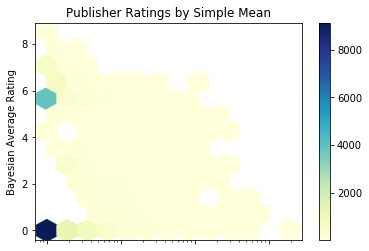

In [31]:
no_zero_ratings_bg_df = clean_bg_df[clean_bg_df['stats.usersrated'] > 0]
# no_zero_ratings_bg_df.describe()

publisher_cleaned_ratings = PublisherRatings(df=no_zero_ratings_bg_df)
publisher_cleaned_ratings.plot_mean_frequency()

Well, that's changed our data a bit, but it's still not terribly helpful. What if we removed all of the games that have a 0 for 'stats.bayesaverage'?

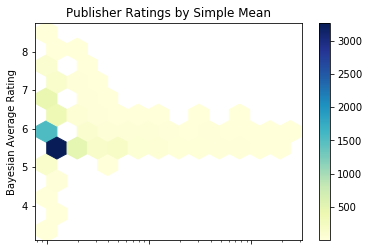

In [32]:
no_zero_bayes_bg_df = clean_bg_df[clean_bg_df['stats.bayesaverage'] > 0]
# no_zero_bayes_bg_df.describe()

publisher_bayescleaned_ratings = PublisherRatings(df=no_zero_bayes_bg_df)
publisher_bayescleaned_ratings.plot_mean_frequency()

Well now we have some interesting data. If we remove all titles that have a 'stats.bayesaverage' score of 0, we start to see a large trending towards 5.5 as the Bayesian Average Rating. Why might this be?

Well, looking into the documentation of Board Game Geeks further, we find out that "30 average ratings (5.5) are added to every rating to form the Bayesian average", which means they aren't really computing the Bayesian Average, but are using a system to simulate a Bayesian Average.

Well, that really throws a wrench in the system, then. How do we fix that?

Well, the surest method is to simply recalculate the Bayesian average for each game ourselves. *sigh* 

While we're at it, let's go ahead and remove all expansions as well, since those aren't games themselves.

Here we go:

In [33]:
recleaned_bg_df = no_zero_ratings_bg_df.dropna(subset = ['stats.usersrated', 'stats.average'])
recleaned_bg_df = recleaned_bg_df[recleaned_bg_df['game.type'] != 'boardgameexpansion']

class GameRatings(object):
    """
    An analytical wrapper that manages access to the data and wraps various
    statistical functions for easy and quick evaluation.
    """

    def __init__(self, df=recleaned_bg_df, m=None, C=None):
        self.df  = df
        self.prior = m
        self.confidence = C
        self.load()

    def load(self):
        """
        Load data from disk into a DataFrame.
        """
        self.data = self.df

    def bayesian_mean(self, arg):
        """
        Computes the Bayesian mean from the prior and confidence.
        """
        if not self.prior or not self.confidence:
            raise TypeError("Bayesian mean must be computed with m and C")

        return (self.confidence * self.prior + (arg['stats.average'] * arg['stats.usersrated'])) / (self.confidence + arg['stats.usersrated'])

    # We won't be able to do a Dirichlet mean unless we get the individual reviews for every single game.
#     def dirichlet_mean(self, arg, prior=PRIOR):
#         """
#         Computes the Dirichlet mean with a prior
#         """
#         counter   = Counter(arg)
#         votes     = [counter.get(n, 0) for n in range(1, 11)]
#         posterior = map(sum, zip(votes, prior))
#         N         = sum(posterior)
#         weights   = map(lambda i: (i[0]+1)*i[1], enumerate(posterior))

#         return float(sum(weights)) / N

#    def get_dirichlet_estimates(self):
#         dirichlet_means = []
#         for index, row in self.games.iterrows():
#             dirichlet = self.dirichlet_mean(row)
#             dirichlet_means.append(dirichlet)
#         return dirichlet_means

#     def top_games_dirichlet(self, n=10):
#         grid   = pd.DataFrame({
#                     'game_name': self.games['details.name'],
#                     'mean':  self.get_means(),
#                     'count': self.get_counts(),
#                     'bayes': self.get_bayesian_estimates(),
#                     'dirichlet': self.get_dirichlet_estimates()
#                  })
#         return grid.sort_values('dirichlet', ascending=False)[0:n]
    
    @property
    def games(self):
        """
        Returns the data grouped by Game ID
        """
        return self.data

    def get_means(self):
        return self.games['stats.average']

    def get_counts(self):
        return self.games['stats.usersrated']

    def get_bayesian_estimates(self):
        bayesian_means = []
        for index, row in self.games.iterrows():
            bayesaverage = self.bayesian_mean(row)
            bayesian_means.append(bayesaverage)
        return bayesian_means

    def top_games(self, n=10):
        grid   = pd.DataFrame({
                    'game_name': self.games['details.name'],
                    'mean':  self.get_means(),
                    'count': self.get_counts(),
                    'bayes': self.get_bayesian_estimates()
                 })
        return grid.sort_values('bayes', ascending=False)[0:n]
    
    def top_listings(self, criteria='details.name', n=10):
        grid   = pd.DataFrame({
                    criteria : self.games[criteria],
                    'mean':  self.get_means(),
                    'count': self.get_counts(),
                    'bayes': self.get_bayesian_estimates()
                 })
        return grid.sort_values('bayes', ascending=False)[0:n]

    def worst_games(self, n=10):
        grid   = pd.DataFrame({
                    'game_name': self.games['details.name'],
                    'mean':  self.get_means(),
                    'count': self.get_counts(),
                    'bayes': self.get_bayesian_estimates()
                 })
        return grid.sort_values('bayes', ascending=True)[0:n]

    def plot_mean_frequency(self):
        grid   = pd.DataFrame({
                    'Average Rating':  self.games['stats.average'],
                    'Number of Reviews': self.games['stats.usersrated']
                 })

        grid.plot(x='Number of Reviews', y='Average Rating', kind='hexbin',
                  xscale='log', cmap='YlGnBu', gridsize=12, mincnt=1,
                  title="Game Ratings by Simple Mean", figsize=(12,8))
        plt.xlabel("Num Reviews")
        plt.show()
    
    def plot_bayesian_frequency(self):
        grid   = pd.DataFrame({
                    'Bayesian Average Rating':  self.games['stats.bayesaverage'],
                    'Number of Reviews': self.games['stats.usersrated']
                 })

        grid.plot(x='Number of Reviews', y='Bayesian Average Rating', kind='hexbin',
                  xscale='log', cmap='YlGnBu', gridsize=12, mincnt=1,
                  title="Game Ratings by Bayesian Mean", figsize=(12,8))
        plt.xlabel("Num Reviews")
        plt.show()
        
    def replace_bayesaverage(self):
        fixed_df = self.games
        for index, row in fixed_df.iterrows():
            bayesaverage = self.bayesian_mean(row)
            fixed_df.at[index,'stats.bayesaverage'] = bayesaverage
        return fixed_df

    def describe(self):
        return self.data.describe()

    def __str__(self):
        return str(self.data.head())

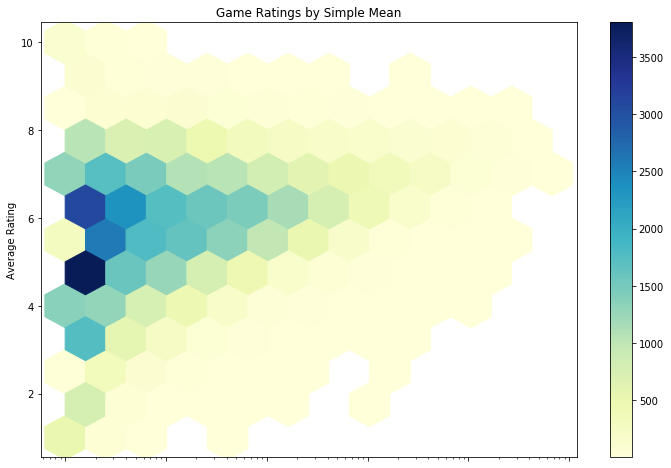

In [34]:
game_ratings = GameRatings(m=4.3, C=10)
game_ratings.plot_mean_frequency()

In [35]:
fixed_bayes_df = game_ratings.replace_bayesaverage()
fixed_bayes_df.describe()

,details.maxplayers,details.maxplaytime,details.minage,details.minplayers,details.minplaytime,details.playingtime,details.yearpublished,attributes.total,stats.average,stats.averageweight,stats.bayesaverage,stats.median,stats.numcomments,stats.numweights,stats.owned,stats.stddev,stats.trading,stats.usersrated,stats.wanting,stats.wishing
count,53694.000000,53694.000000,53694.000000,53694.000000,53694.000000,53694.000000,53694.000000,53696.000000,53696.000000,53696.000000,53696.000000,53696.0,53696.000000,53696.000000,53696.000000,53696.000000,53696.000000,53696.000000,53696.000000,53696.000000
mean,5.611111,56.385443,7.396208,2.025999,50.424573,56.385443,1855.171714,4.892990,5.686725,1.117176,5.081119,0.0,53.069893,15.670683,292.151445,1.248183,10.976646,182.336599,12.221823,47.576430
std,52.525268,411.413165,4.739702,0.791812,393.497193,411.413165,519.558168,1.179117,1.452259,1.137985,0.901854,0.0,298.441665,110.508609,1813.267012,0.940280,45.734206,1335.341638,63.316712,285.040144
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3500.000000,1.000000,1.000000,0.000000,1.747457,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,2.000000,15.000000,4.000000,2.000000,10.000000,15.000000,1987.000000,4.000000,5.000000,0.000000,4.416667,0.0,1.000000,0.000000,4.000000,0.500000,0.000000,2.000000,0.000000,0.000000
50%,4.000000,30.000000,8.000000,2.000000,30.000000,30.000000,2004.000000,5.000000,5.909090,1.000000,4.781249,0.0,3.000000,1.000000,15.000000,1.305630,1.000000,6.000000,1.000000,2.000000
75%,6.000000,60.000000,12.000000,2.000000,60.000000,60.000000,2011.000000,6.000000,6.699955,2.000000,5.618808,0.0,16.000000,4.000000,82.000000,1.674980,4.000000,32.000000,3.000000,10.000000
max,11299.000000,60120.000000,99.000000,40.000000,60120.000000,60120.000000,2019.000000,10.000000,10.000000,5.000000,9.147320,0.0,13841.000000,6448.000000,95401.000000,4.500000,1858.000000,67655.000000,1838.000000,9082.000000


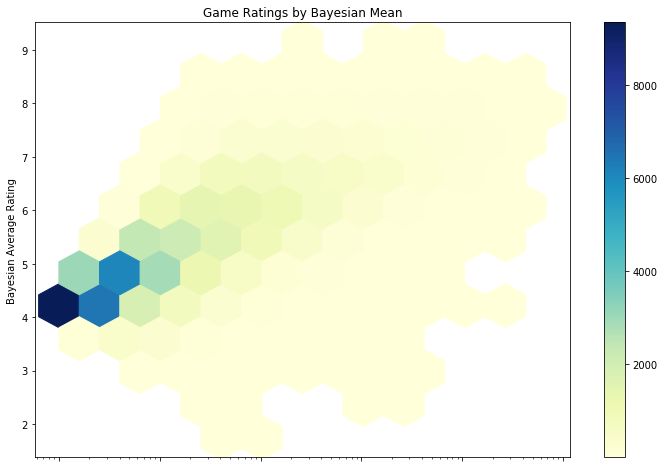

In [36]:
game_ratings_fixed = GameRatings(df=fixed_bayes_df)
game_ratings_fixed.plot_bayesian_frequency()

In [37]:
game_ratings.top_listings('details.maxplayers')


,bayes,count,details.maxplayers,mean
80093,9.147320,251.0,4.0,9.34044
75624,9.121965,3503.0,4.0,9.13573
41204,8.908256,1954.0,6.0,8.93184
81613,8.837203,362.0,4.0,8.96254
63507,8.756345,180.0,6.0,9.00392
74893,8.749460,176.0,5.0,9.00227
78529,8.735910,6888.0,4.0,8.74235
83513,8.694447,98.0,4.0,9.14286
71064,8.666249,17251.0,4.0,8.66878
89324,8.641024,68.0,6.0,9.27941


game_ratings.worst_games(10)

## Huzzah! We've Saved the Baye!

Now that we've cleared that up, let's start analyzing!

### Analyzing What?

Huh. Well that is a good question. Originally, we wanted to figure out who the best publishers are, but that seems to have fallen by the wayside with the necessity to fix the Bayesian averages of the game reviews. Now that we've fixed that, I wonder if we might try finding the best publishers again.

To do that, let's use our new data frame, which includes the adjusted Bayesian Averages for each of the games.

In [38]:
publisher_ratings = PublisherRatings(df = fixed_bayes_df, m=6, C=3)

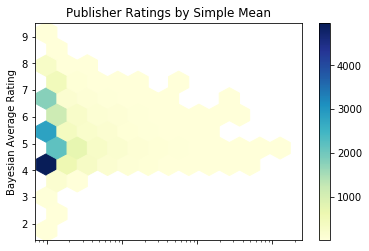

In [39]:
publisher_ratings.plot_mean_frequency()

In [40]:
publisher_ratings.top_publishers()

,bayes,count,dirichlet,mean
attributes.boardgamepublisher,,,,
Corglenburg Ltd.,5.884911,1,0.0,5.539643
"Corx, Inc.",5.718749,1,0.0,4.874998
Corvinus Press,5.659091,1,0.0,4.636364
"Corvinia,Present Games Ltd",5.636364,1,0.0,4.545455
Corvid Games,5.882200,2,0.0,5.705499
Cortoys International,5.585938,1,0.0,4.343751
"Corsair Publishing, LLC",5.540140,2,0.0,4.850350
Corporate Games 96 Ltd.,5.568182,1,0.0,4.272727
Corvus Belli,6.799233,2,0.0,7.998082


## Something's Wrong

Taking a quick glance at the list printed out using publisher_ratings.top_publishers, we immediately notice that something is wrong: Despite the values being adjusted, there does't seem to be any rhyme or reason to the order of the listed companies. Why is that?

Well, if we take a look at the class declaration, we see that the results of "top_publishers()" are sorted by the "dirichlet" calculation. Looking at the data printed out, we see that all of the "dirichlet" scores are 0.0. What might we do to fix this?

Well, first off, let's take a look at the class again. It's possible we may need to make adjustments to the class methods to suit our data structure. Remember, these methods were originally taken from the article, which was created to analyze movie ratings from a specific data set, so it makes sense that we'd need to adjust it a bit to fit our data.

In [41]:
PRIOR = [2,2,2,2,2,2,2,2,2,2]

class PublisherRatings(object):
    """
    An analytical wrapper that manages access to the data and wraps various
    statistical functions for easy and quick evaluation.
    """

    def __init__(self, df=clean_bg_df, m=None, C=None):
        self.df  = df
        self.prior = m
        self.confidence = C
        self.load()

    def load(self):
        """
        Load data from disk into a DataFrame.
        """
        self.data = self.df

    def bayesian_mean(self, arr):
        """
        Computes the Bayesian mean from the prior and confidence.
        """
        if not self.prior or not self.confidence:
            raise TypeError("Bayesian mean must be computed with m and C")

        return (self.confidence * self.prior + arr.sum()) / (self.confidence + arr.count())

    def dirichlet_mean(self, arr, prior=PRIOR):
        """
        Computes the Dirichlet mean with a prior.
        """
        print(arr)
        counter   = Counter(arr)
        votes     = [counter.get(n, 0) for n in range(1, 11)]
        posterior = map(sum, zip(votes, prior))
        print("Posterior = " + str(list(posterior)))
        N         = sum(posterior)
        print("N = " + str(N))
        weights   = map(lambda i: (i[0]+1)*i[1], enumerate(posterior))
        print("weights = " + str(weights))
        print("return = " + str(float(sum(weights)) / N))
        return float(sum(weights)) / N

    @property
    def publishers(self):
        """
        Returns the data grouped by Publisher
        """
        return self.data.groupby('attributes.boardgamepublisher')

    def get_means(self):
        return self.publishers['stats.bayesaverage'].mean()

    def get_counts(self):
        return self.publishers['stats.bayesaverage'].count()

    def get_bayesian_estimates(self):
        return self.publishers['stats.bayesaverage'].agg(self.bayesian_mean)

    def get_dirichlet_estimates(self):
        return self.publishers['stats.bayesaverage'].agg(self.dirichlet_mean)

    def top_publishers(self, n=10):
#         grid   = pd.DataFrame({
#                     'mean':  self.get_means(),
#                     'count': self.get_counts(),
#                     'bayes': self.get_bayesian_estimates(),
#                     'dirichlet': self.get_dirichlet_estimates()
#                  })
#         return grid.iloc[grid['dirichlet'].argsort()[-n:]]
         grid   = pd.DataFrame({
                    'mean':  self.get_means(),
                    'count': self.get_counts(),
                    'bayes': self.get_bayesian_estimates()
                 })
         return grid.sort_values('bayes', ascending=False)[0:n]

    def plot_mean_frequency(self):
        grid   = pd.DataFrame({
                    'Bayesian Average Rating':  self.publishers['stats.bayesaverage'].mean(),
                    'Number of Games': self.publishers['game.id'].count()
                 })

        grid.plot(x='Number of Games', y='Bayesian Average Rating', kind='hexbin',
                  cmap='YlGnBu', gridsize=12, mincnt=1,
                  title="Publisher Ratings by Simple Mean")
        plt.show()

    def describe(self):
        return self.data.describe()

    def __str__(self):
        return str(self.data.head())

In [42]:
publisher_ratings2 = PublisherRatings(df=fixed_bayes_df, m=5.5, C=2)

In [43]:
publisher_ratings2.top_publishers()

,bayes,count,mean
attributes.boardgamepublisher,,,
Chip Theory Games,7.221356,4,8.082034
Hexasim,7.148474,9,7.514801
Multi-Man Publishing,7.031634,67,7.077355
"The Gamers,Multi-Man Publishing",6.993457,18,7.159396
"Avalon Hill,Multi-Man Publishing",6.980134,7,7.403030
Sirlin Games,6.896773,14,7.096312
Flying Frog Productions,6.889109,8,7.236386
"Asterion Press,Edge Entertainment,Fantasy Flight Games,Galakta,Galápagos Jogos,Heidelberger Spieleverlag",6.877859,2,8.255719
Draco Ideas,6.870834,3,7.784724


## Eureka!

It seems we finally have some interesting results from all of this data wrangling!

Now, the question we have to wonder is how do our "m" and "C" affect the output? Moreover, what are "m" and "C". 

## m and C

Put simply, m is the expected average, while C is the number of data points we expect to need (i.e. how many games a company has published) before we expect that the results match the trend we see in the data.

Well, let's see if m=5.5 and C=2 are accurate representations but looking at a visualization of the data. 

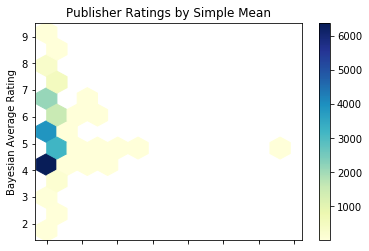

In [44]:
publisher_ratings2.plot_mean_frequency()

## What does this mean?

Well, according to the chart above, the average score we can expect for a company with 1 game pulished is about 5.5, maybe slightly higher. If the company has more than 1 game published, it still tends to stick towards this value. 

Based on this chart, we learn 1 other thing as well: Most of the unique Publisher listings in the database have only 1 game published.

This doesn't make much sense, until we think back to what "unique Publisher" means. When we looked at the data before, we saw that there weer several publishers listed multiple times, but that they were often listed as working with several other companies. In these type of groupings, each grouping counts as an individual publisher, given the way we've processed the data. How might we fix this?

Well, the only way I know of off the top of my head is to sort through all of the data and split each row into individual companies. This is going to be tough, however, as there are hundreds of publishing companies. How might we accomplish this without typing out every single publisher manually?

In [45]:
publishers_list = fixed_bayes_df['attributes.boardgamepublisher'].unique()
publishers_list_expanded = []

for index, publisher in enumerate(publishers_list):
    if (publisher == None):
        continue
    split_pubs = re.compile(',(?! )').split(publisher)
    publishers_list_expanded += split_pubs
    
publishers_list_expanded = list(sorted(set(publishers_list_expanded)))
print(publishers_list_expanded)

['', '"Let\'s Talk" Company', '#14 Productions', '(Public Domain)', '(Self-Published)', '(Unknown)', '(Unpublished)', '(Web published)', '0 hr art & technology', '1 Stein Spiele', '1% Inspiration Games, Inc.', '1-2-3-Games Éditions', '10-Productions', '10-Shiki Gameworks', '100 Plus, Inc.', '10th Dimension Studios', '12SP Entertainment', '1300 Games', '13Rentgen', '15mm.co.uk', '1602 éditions', '1745 Trading Company', '17gonplay', '1979games', '1A Games', '1A Spiele GmbH', '1CONZEPT', '1X1 Spiele', '1YOO!', '1nite werewolf', '2 Creativos', '2 Handsome Games', '20 Fingers Productions', '20-Grit Games', '2000 AD Comic', '2020 Associates', '20th Century Fox', '25th Century Games', '2D10', '2D6.EE', '2F-Spiele', '2Geeks', '2K Games, Inc.', '2RS Games', '2Tomatoes', '2mt Games', '3 Headed Giant Games', '3 History Geeks', '3 Man Chess', '3 Star Entertainment', '3-Hirn-Verlag', '30mm Midwestern Napoleonic Wargamers Confederation', '323 Studio', '3D6 Games', '3D6 SRL', '3DTotal Games', '3J Gam

# Holy Shit It Worked!

Pardon my French, but...wow. What a nightmare. We finally have all of the unique publisher names now! There's a chance that some of the names may not have been split properly, but dog-gonnit, it's close enough.

So, what now? Well, as we said before, we're going to have to split up each row (i.e. each game) based on all of the publishers and duplicate those rows for each publisher, so that we can figure out how prolific all of these publishers really are.

We already fixed the games by replacing their Bayesian Averages, so we can probably use some similar code to duplicate rows while iterating.

In [46]:
fixed_bayes_df.describe()

,details.maxplayers,details.maxplaytime,details.minage,details.minplayers,details.minplaytime,details.playingtime,details.yearpublished,attributes.total,stats.average,stats.averageweight,stats.bayesaverage,stats.median,stats.numcomments,stats.numweights,stats.owned,stats.stddev,stats.trading,stats.usersrated,stats.wanting,stats.wishing
count,53694.000000,53694.000000,53694.000000,53694.000000,53694.000000,53694.000000,53694.000000,53696.000000,53696.000000,53696.000000,53696.000000,53696.0,53696.000000,53696.000000,53696.000000,53696.000000,53696.000000,53696.000000,53696.000000,53696.000000
mean,5.611111,56.385443,7.396208,2.025999,50.424573,56.385443,1855.171714,4.892990,5.686725,1.117176,5.081119,0.0,53.069893,15.670683,292.151445,1.248183,10.976646,182.336599,12.221823,47.576430
std,52.525268,411.413165,4.739702,0.791812,393.497193,411.413165,519.558168,1.179117,1.452259,1.137985,0.901854,0.0,298.441665,110.508609,1813.267012,0.940280,45.734206,1335.341638,63.316712,285.040144
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3500.000000,1.000000,1.000000,0.000000,1.747457,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,2.000000,15.000000,4.000000,2.000000,10.000000,15.000000,1987.000000,4.000000,5.000000,0.000000,4.416667,0.0,1.000000,0.000000,4.000000,0.500000,0.000000,2.000000,0.000000,0.000000
50%,4.000000,30.000000,8.000000,2.000000,30.000000,30.000000,2004.000000,5.000000,5.909090,1.000000,4.781249,0.0,3.000000,1.000000,15.000000,1.305630,1.000000,6.000000,1.000000,2.000000
75%,6.000000,60.000000,12.000000,2.000000,60.000000,60.000000,2011.000000,6.000000,6.699955,2.000000,5.618808,0.0,16.000000,4.000000,82.000000,1.674980,4.000000,32.000000,3.000000,10.000000
max,11299.000000,60120.000000,99.000000,40.000000,60120.000000,60120.000000,2019.000000,10.000000,10.000000,5.000000,9.147320,0.0,13841.000000,6448.000000,95401.000000,4.500000,1858.000000,67655.000000,1838.000000,9082.000000


## Pre-Work

Before we start doing this, I wanted to take a look at what the existing dataframe looks like, so that I can compare it later. 

Next, I want to build an empty dataframe with the same format as our existing data. Afterwards, I'm going to iterate through all of the data and add all of the items to the new dataframe, with each game copied multiple times for each of its publishers. This should give us better insight to how many games publishers have actually worked on.

In [47]:
enumerated_publishers_df = pd.DataFrame.from_items([(name, pd.Series(data=None, dtype=series.dtype))
                                        for name, series in fixed_bayes_df.iteritems()])


enumerated_publishers_df.describe()

,details.maxplayers,details.maxplaytime,details.minage,details.minplayers,details.minplaytime,details.playingtime,details.yearpublished,attributes.total,stats.average,stats.averageweight,stats.bayesaverage,stats.median,stats.numcomments,stats.numweights,stats.owned,stats.stddev,stats.trading,stats.usersrated,stats.wanting,stats.wishing
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
# total_rows = len(fixed_bayes_df)
# for index, row in fixed_bayes_df.iterrows():
#     publishers = re.compile(',(?! )').split(row['attributes.boardgamepublisher'])
#     for publisher in publishers:
#         fixed_row = row
#         fixed_row['attributes.boardgamepublisher'] = publisher
#         enumerated_publishers_df = enumerated_publishers_df.append(fixed_row, ignore_index = True)
#     print(str(index) + "/" + str(total_rows))

In [49]:
enumerated_publishers_df.describe()

,details.maxplayers,details.maxplaytime,details.minage,details.minplayers,details.minplaytime,details.playingtime,details.yearpublished,attributes.total,stats.average,stats.averageweight,stats.bayesaverage,stats.median,stats.numcomments,stats.numweights,stats.owned,stats.stddev,stats.trading,stats.usersrated,stats.wanting,stats.wishing
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
pr_columns = ["Publisher", "Average Game Rating (Bayes)", "Total Ratings" ]

publisher_rankings_df = pd.DataFrame(columns=pr_columns)

for index, publisher in enumerate(publishers_list_expanded):
    new_row = [index, publisher, 0, 0]
    publisher_rankings_df.loc[index] = new_row

publisher_rankings_df.describe()

# print(len(publishers_list_expanded))


ValueError: cannot set a row with mismatched columns

In [50]:
class PublisherRatings(object):
    """
    An analytical wrapper that manages access to the data and wraps various
    statistical functions for easy and quick evaluation.
    """

    def __init__(self, df=clean_bg_df, m=None, C=None):
        self.df  = df
        self.prior = m
        self.confidence = C
        # publisher_ratings[publisher_name] = [game_ratings]
        self.publisher_ratings = {}
        self.load()

    def load(self):
        """
        Load data from disk into a DataFrame.
        """
        self.data = self.df

    def bayesian_mean(self, arr):
        """
        Computes the Bayesian mean from the prior and confidence.
        """
        if not self.prior or not self.confidence:
            raise TypeError("Bayesian mean must be computed with m and C")

        return (self.confidence * self.prior + arr.sum()) / (self.confidence + arr.count())

    def dirichlet_mean(self, arr, prior=PRIOR):
        """
        Computes the Dirichlet mean with a prior.
        """
        print(arr)
        counter   = Counter(arr)
        votes     = [counter.get(n, 0) for n in range(1, 11)]
        posterior = map(sum, zip(votes, prior))
        print("Posterior = " + str(list(posterior)))
        N         = sum(posterior)
        print("N = " + str(N))
        weights   = map(lambda i: (i[0]+1)*i[1], enumerate(posterior))
        print("weights = " + str(weights))
        print("return = " + str(float(sum(weights)) / N))
        return float(sum(weights)) / N

    @property
    def publishers(self):
        """
        Returns the data grouped by Publisher
        """
        return self.data.groupby('attributes.boardgamepublisher')

    def get_means(self):
        return self.publishers['stats.bayesaverage'].mean()

    def get_counts(self):
        return self.publishers['stats.bayesaverage'].count()

    def get_bayesian_estimates(self):
        return self.publishers['stats.bayesaverage'].agg(self.bayesian_mean)

    def get_dirichlet_estimates(self):
        return self.publishers['stats.bayesaverage'].agg(self.dirichlet_mean)
    
    def split_pubs_and_store(self, game):
        split_pubs = re.compile(',(?! )').split(game['attributes.boardgamepublisher'])
        for publisher in split_pubs:
            if (type(self.publisher_ratings[publisher]) != list):
                self.publisher_ratings[publisher] = []
            self.publisher_ratings[publisher].append(game['stats.bayesaverage'])

    def top_publishers(self, n=10):
#         grid   = pd.DataFrame({
#                     'mean':  self.get_means(),
#                     'count': self.get_counts(),
#                     'bayes': self.get_bayesian_estimates(),
#                     'dirichlet': self.get_dirichlet_estimates()
#                  })
#         return grid.iloc[grid['dirichlet'].argsort()[-n:]]
         grid   = pd.DataFrame({
                    'mean':  self.get_means(),
                    'count': self.get_counts(),
                    'bayes': self.get_bayesian_estimates()
                 })
         return grid.sort_values('bayes', ascending=False)[0:n]

    def plot_mean_frequency(self):
        grid   = pd.DataFrame({
                    'Bayesian Average Rating':  self.publishers['stats.bayesaverage'].mean(),
                    'Number of Games': self.publishers['game.id'].count()
                 })

        grid.plot(x='Number of Games', y='Bayesian Average Rating', kind='hexbin',
                  cmap='YlGnBu', gridsize=12, mincnt=1,
                  title="Publisher Ratings by Simple Mean")
        plt.show()

    def describe(self):
        return self.data.describe()

    def __str__(self):
        return str(self.data.head())

In [51]:
publisher_ratings = {}

print(fixed_bayes_df.loc[fixed_bayes_df['game.id'] == 3]['attributes.boardgamepublisher'])


split_pubs = re.compile(',(?! )').split(str(fixed_bayes_df.loc[fixed_bayes_df['game.id'] == 3]['attributes.boardgamepublisher']))
for publisher in split_pubs:
    if (type(publisher_ratings[publisher]) != list):
        publisher_ratings[publisher] = []
    publisher_ratings[publisher].append(fixed_bayes_df.loc[[2]]['stats.bayesaverage'])
    
for k, v in publisher_ratings.iteritems():
    print(k, v)

Series([], Name: attributes.boardgamepublisher, dtype: object)


KeyError: 'Series([], Name: attributes.boardgamepublisher, dtype: object)'

In [ ]:
clean_bg_df.sort_values('stats.average', ascending=False)[0:10]['details.name']

In [ ]:
clean_bg_df.sort_values('stats.average', ascending=False)[0:10]['stats.usersrated']

In [ ]:
clean_bg_df.sort_values('stats.average', ascending=False)[0:10]['stats.average']

In [ ]:
clean_bg_df['stats.average'].mean()